### vi. Attacker relationship (how do they claim to know the victim, 1) met online? 2) friend of a friend?, 3) met the victim in person before)

#### Example sentences:
- I **got your contact during** one of my recent official trips to S/korea March/April this year as one of the  Economic Community of West African States (ECOWAS) Delegates accredited by the Korea Trade Promotion Agency (KOTRA) office to attend your  Trade Missions-the Korean International Commercial and Special Vehicle show tagged "CSV SHOW 2006" held there between Wednesday the 29th of March to Saturday Ist April 2006.
- I **got your contact from** a close Associate of mine who works with the Nigerian Chamber of Commerce and Industry  who visited your country for an International Trade Fair upon my quest for a trusted and reliable foreign businessman or company. 
- I GUESS THIS LETTER MAY COME TO YOU AS SURPRISE SINCE I **HAD NO PREVIOUS CORRESPONDENCE WITH YOU**.
- I know this letter will come to you as surprise. **I managed to get your contact line from** the Cote Divoire Chamber of Commerce, hence I did not waste time to contact you on a business proposal. 


#### Boolean Question Answering (Train a model from google dataset and use it in the email)

Model training code is taken from here: [Deep Learning has (almost) all the answers: Yes/No Question Answering with Transformers](https://medium.com/illuin/deep-learning-has-almost-all-the-answers-yes-no-question-answering-with-transformers-223bebb70189)

Trained using: `booleanQATraining.py`

#### Download model from google drive:

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model.to(device) # Send the model to the GPU if we have one

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
train_data_df = pd.read_json("Data/google-research-datasets-boolean-questions/train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("Data/google-research-datasets-boolean-questions/dev.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

# Building Dataloaders
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

epochs = 5
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):
    # Training
    epoch_train_loss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)
  
    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()

    for batch in dev_dataloader:
    
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]
                    
        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

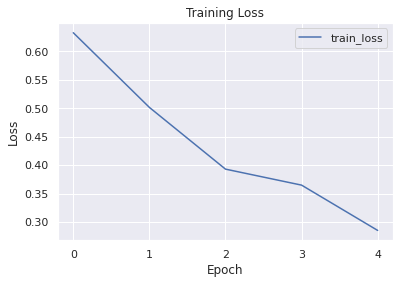

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

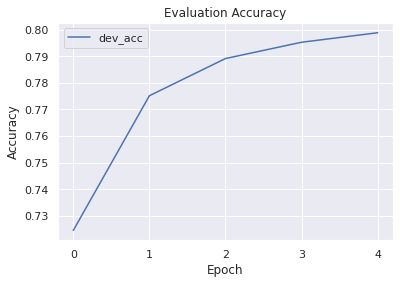

In [4]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

In [7]:
def predict(question, passage):
    sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)
    logits = model(sequence)[0]
    probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
    proba_yes = round(probabilities[1], 2)
    proba_no = round(probabilities[0], 2)

    print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")

In [6]:
passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
                    (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
                    the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
                    The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
                    California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
                    gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
                    with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
                    prominently feature the Arabic numerals 50."""
 
passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
                  and the new means of human interaction this technology enables."""

superbowl_questions = [
"Did the Denver Broncos win the Super Bowl 50?", 
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?", 
"Was the Super Bowl 50 played in Las Vegas?", 
"Was the Super Bowl 50 played in February?", 
"Was the Super Bowl 50 played in March?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

for s_question in superbowl_questions:
    predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)

Question: Did the Denver Broncos win the Super Bowl 50?, Yes: 1.0, No: 0.0
Question: Did the Carolina Panthers win the Super Bowl 50?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl played at Levi's Stadium?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl 50 played in Las Vegas?, Yes: 0.89, No: 0.11
Question: Was the Super Bowl 50 played in February?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl 50 played in March?, Yes: 0.02, No: 0.98
Question: Is Illuin the answer to your strategic needs?, Yes: 1.0, No: 0.0


In [8]:
torch.save(model, 'Models/booleanQA_batchSize8.pth')

---

In [20]:
import gdown
import os

if not os.path.exists('Models'):
    os.makedirs('Models')

url = 'https://drive.google.com/uc?id=1j-nbX7eZDKHVgcKbYvIdXenb0iCYClM9'
output = 'Models/booleanQA_batchSize8.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1j-nbX7eZDKHVgcKbYvIdXenb0iCYClM9
To: /Users/anthony/Documents/GitHub/DSCI-550-Assignment-1/notebooks/Models/booleanQA_batchSize8.pth
499MB [00:10, 48.3MB/s] 


'Models/booleanQA_batchSize8.pth'

In [2]:
import torch
# Then later:
model = torch.load('Models/booleanQA_batchSize8.pth', map_location=torch.device('cpu') )

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("roberta-base") 
def predict(question, passage):
    sequence = tokenizer.encode_plus(question, passage, return_tensors="pt", max_length=512, truncation=True)['input_ids'].to(device)
    logits = model(sequence)[0]
    probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
    proba_yes = round(probabilities[1], 4)
    proba_no = round(probabilities[0], 4)

    print(f"Question: {question}\n\tYes: {proba_yes}, No: {proba_no}")

Test:

In [9]:
passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
                    (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
                    the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
                    The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
                    California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
                    gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
                    with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
                    prominently feature the Arabic numerals 50."""
 
passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
                  and the new means of human interaction this technology enables."""

superbowl_questions = [
"Did the Denver Broncos win the Super Bowl 50?", 
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?", 
"Was the Super Bowl 50 played in Las Vegas?", 
"Was the Super Bowl 50 played in February?", 
"Was the Super Bowl 50 played in March?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

for s_question in superbowl_questions:
    predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)

Question: Did the Denver Broncos win the Super Bowl 50?, Yes: 0.9984, No: 0.0016
Question: Did the Carolina Panthers win the Super Bowl 50?, Yes: 0.9984, No: 0.0016
Question: Was the Super Bowl played at Levi's Stadium?, Yes: 0.9978, No: 0.0022
Question: Was the Super Bowl 50 played in Las Vegas?, Yes: 0.8903, No: 0.1097
Question: Was the Super Bowl 50 played in February?, Yes: 0.9981, No: 0.0019
Question: Was the Super Bowl 50 played in March?, Yes: 0.0203, No: 0.9797
Question: Is Illuin the answer to your strategic needs?, Yes: 0.9983, No: 0.0017


#### Apply question to the emails:

In [17]:
import json
import os
from ftfy import fix_text
import re
from transformers import pipeline

nlp = pipeline("question-answering")


PATH = '../data/separated by email/'

for email in os.listdir(PATH):
    print(email)
    
    j = json.load(open(os.path.join(PATH, email)))
    if 'X-TIKA:content' not in j:
        print(email, "does not have 'X-TIKA:content' key")
        continue
    text = j['X-TIKA:content']
    text_cleaned = fix_text(text).strip()
    text_cleaned = re.sub(r'(\n\s*)+', ' ', text_cleaned) # replace multiple newlines to single newline
    text_cleaned = re.sub(r'\S*@\S*\s?', ' ', text_cleaned) # remove email addresses so that the QA model may perfrom well
    text_cleaned = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text_cleaned) #
    
    context = text_cleaned
    
#     print(context)
    
    questions = [
        "Who am I?",
        "How did I get your contact?",
        "When did I get your contact?",
        "Where did I get your contact?",
        "Why am I contacting you?",
        "How did we met?",
        "How did I know you?"
    ]
    
    booleanQuestions = [
        "Did we meet online?",
        "Did I know your friend?",
        "Did we meet in person before?"
    ]
    
    print('\nwh-questions:')
    for question in questions:
        answer = nlp(question=question, context=context)
        print(question)
        print(f"\tscore: {round(answer['score'],4)}")
        print('\tAnswer:', answer['answer'])
    
    print('\nYes-no questions:')
    for bquestion in booleanQuestions:
        predict(bquestion, context)
        
    print('\n-------\n')
        

3721.json

wh-questions:
Who am I?
	score: 0.5289
	Answer: Dr Kenneth cole
How did I get your contact?
	score: 0.0668
	Answer: via any of the corresponding banks in London or Spain
When did I get your contact?
	score: 0.0976
	Answer: gradually
Where did I get your contact?
	score: 0.1814
	Answer: Escrow
Why am I contacting you?
	score: 0.7032
	Answer: in anticipation for your prompt response
How did we met?
	score: 0.018
	Answer: From Dr Kenneth Independent Committee of Eminent Persons
How did I know you?
	score: 0.119
	Answer: numbered account in your name and country

Yes-no questions:
Question: Did we meet online?
	Yes: 0.9982, No: 0.0018
Question: Did I know your friend?
	Yes: 0.9985, No: 0.0015
Question: Did we meet in person before?
	Yes: 0.9983, No: 0.0017

-------

2833.json

wh-questions:
Who am I?
	score: 0.9806
	Answer: Kofi Achampong
How did I get your contact?
	score: 0.1066
	Answer: during one of my recent official trips
When did I get your contact?
	score: 0.5201
	Answer

KeyboardInterrupt: 

### ix. Attacker estimated age. You will use the USC Data Science AgePredictor, here: https://github.com/USCDataScience/AgePredictor